In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

from utils import Box, boxes_drawing
from utils import network_to_boxes
from keras.backend import set_image_dim_ordering
# 保证你使用的通道顺序和配置的通道顺序一致
# more to see : https://github.com/fchollet/keras/issues/2681
set_image_dim_ordering('th')

Using TensorFlow backend.


## build yolo model (tiny yolo model)


In [2]:
from tiny_yolo_model import tiny_yolo

model = tiny_yolo()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 448, 448)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 16, 448, 448)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 224, 224)  0           leakyrelu_1[0][0]                
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 224, 224)  4640        maxpooling2d_1[0][0]             
___________________________________________________________________________________________


## load pretrained weights file

this pretrained weights is from COCO image dataset, which is a focus on object recognition within the broader context of scence understanding.

In [3]:
def load_trained_weights(model, weight_file):
                
    weights = np.fromfile(weight_file,np.float32)
    weights = weights[4:]
    
    idx = 0
    for layer in model.layers:
        shape = [wi.shape for wi in layer.get_weights()]
        if shape != []:
            W_shape, b_shape = shape
            bias = weights[idx:idx+np.prod(b_shape)].reshape(b_shape)
            idx += np.prod(b_shape)
            W = weights[idx:idx+np.prod(W_shape)].reshape(W_shape)
            idx += np.prod(W_shape)
            layer.set_weights([W, bias])

In [4]:
load_trained_weights(model,'yolo-tiny.weights')

## apply the model to a test image ##

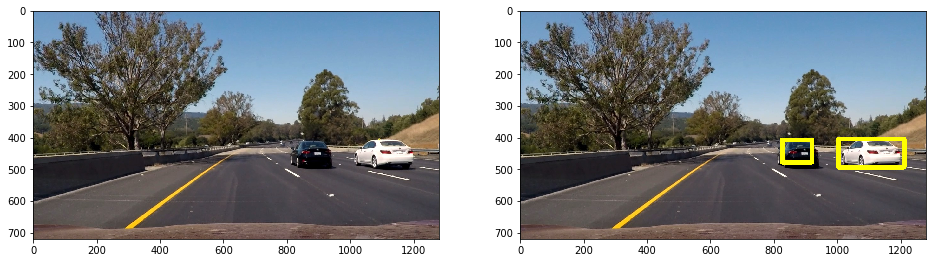

In [5]:
def Pipeline(img):
    # 为了展示原有图片与添加box图片的区别
    copy_img = np.copy(img)       # 可删去
    # 剪切图片
    cropped_img = img[300:650,500:,:]
    # COCO数据集尺寸 448X448
    resized_img = cv2.resize(cropped_img,(448,448))
    # 提取颜色 （可省略）
    color_batch = np.array([resized_img[:,:,0],resized_img[:,:,1],resized_img[:,:,2]])
    # 均一化
    nor_batch = 2*(color_batch/255.) - 1
    nor_batch = np.expand_dims(nor_batch, axis=0)
    # 得到每个网格点的probability
    out = model.predict(nor_batch)
    # 得到box
    boxes = network_to_boxes(out[0], threshold = 0.17)
    # 返回
    return boxes_drawing(copy_img,boxes, )

test_imgs_path = 'test_images/test6.jpg'
img = plt.imread(test_imgs_path)
boxes_img = Pipeline(img) 
f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.imshow(img)
ax2.imshow(boxes_img)

more examples

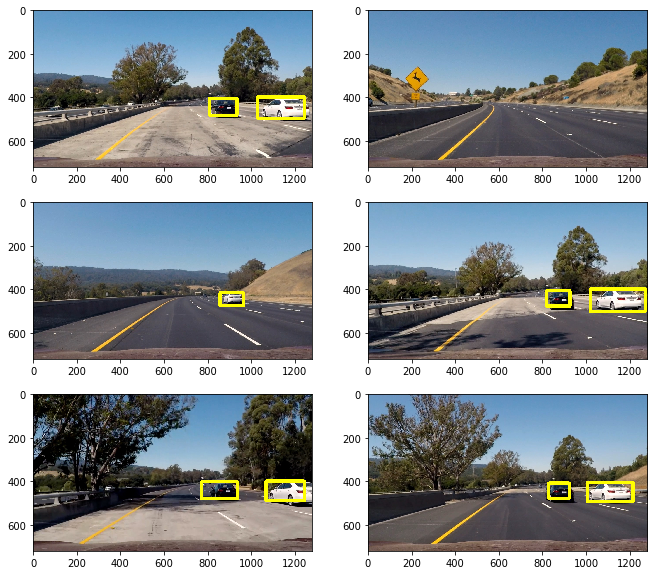

In [6]:
imgs_path =  glob.glob('./test_images/*.jpg')
imgs_list = []
for img_path in imgs_path:
    imgs_list.append(plt.imread(img_path))
num = len(imgs_list)
f,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(11,10))
for i,ax in zip(range(num),[ax1,ax2,ax3,ax4,ax5,ax6]):
    boxes_img = Pipeline(imgs_list[i])
    ax.imshow(boxes_img)

## Apply detection and lane line finding to video

In [9]:
project_video_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")

In [10]:
lane_clip = clip1.fl_image(Pipeline) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_detection_out.mp4
[MoviePy] Writing video challenge_video_detection_out.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:46<00:00, 10.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_detection_out.mp4 

Wall time: 47 s


## Combine land line finding
video has uploaded: []()

In [7]:
from LaneFinding.imgs_transf import Undistort, PerspectiveTransform
from LaneFinding.imgs_processing import Processing
from LaneFinding.lines_finding import LinesFinding
from LaneFinding.imgs_drawing import Drawing

In [8]:
line = LinesFinding()

def LaneFinding(img):
    undist = Undistort(img)
    warped = PerspectiveTransform(undist)
    bin_warped = Processing(warped)
    
    if not line.is_found:
        line.window_search(bin_warped)
    else:
        line.direct_search(bin_warped)
    ploty = line.ploty
    leftx = line.left_fitx
    rightx = line.right_fitx
    curve_rad = line.curve_rad
    position = line.position 
    result = Drawing(undist, bin_warped, leftx, rightx, ploty, curve_rad, position)
    return result

project_video_output = 'upload.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip2 = clip1.fl_image(LaneFinding)
lane_clip = clip2.fl_image(Pipeline)
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_detection_out.mp4
[MoviePy] Writing video project_video_detection_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:32<00:00,  4.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_detection_out.mp4 

Wall time: 4min 33s
